# Custom potential

We solve the 1D Gross-Pitaevskii equation with a custom potential.
This is similar to Gross-Pitaevskii equation in 1D example
and we show how to define local potentials attached to atoms, which allows for
instance to compute forces.
The custom potential is actually already defined as `ElementGaussian` in DFTK, and could
be used as is.

In [1]:
using DFTK
using LinearAlgebra

First, we define a new element which represents a nucleus generating
a Gaussian potential.

In [2]:
struct CustomPotential <: DFTK.Element
    α  # Prefactor
    L  # Width of the Gaussian nucleus
end

Some default values

In [3]:
CustomPotential() = CustomPotential(1.0, 0.5);

We extend the two methods providing access to the real and Fourier
representation of the potential to DFTK.

In [4]:
function DFTK.local_potential_real(el::CustomPotential, r::Real)
    -el.α / (√(2π) * el.L) * exp(- (r / el.L)^2 / 2)
end
function DFTK.local_potential_fourier(el::CustomPotential, p::Real)
    # = ∫ V(r) exp(-ix⋅p) dx
    -el.α * exp(- (p * el.L)^2 / 2)
end

> **Gaussian potentials and DFTK**
>
> DFTK already implements `CustomPotential` in form of the `DFTK.ElementGaussian`,
> so this explicit re-implementation is only provided for demonstration purposes.

We set up the lattice. For a 1D case we supply two zero lattice vectors

In [5]:
a = 10
lattice = a .* [[1 0 0.]; [0 0 0]; [0 0 0]];

In this example, we want to generate two Gaussian potentials generated by
two "nuclei" localized at positions $x_1$ and $x_2$, that are expressed in
$[0,1)$ in fractional coordinates. $|x_1 - x_2|$ should be different from
$0.5$ to break symmetry and get nonzero forces.

In [6]:
x1 = 0.2
x2 = 0.8
positions = [[x1, 0, 0], [x2, 0, 0]]
gauss     = CustomPotential()
atoms     = [gauss, gauss];

We setup a Gross-Pitaevskii model

In [7]:
C = 1.0
α = 2;
n_electrons = 1  # Increase this for fun
terms = [Kinetic(),
         AtomicLocal(),
         LocalNonlinearity(ρ -> C * ρ^α)]
model = Model(lattice, atoms, positions; n_electrons, terms,
              spin_polarization=:spinless);  # use "spinless electrons"

We discretize using a moderate Ecut and run a SCF algorithm to compute forces
afterwards. As there is no ionic charge associated to `gauss` we have to specify
a starting density and we choose to start from a zero density.

In [8]:
basis = PlaneWaveBasis(model; Ecut=500, kgrid=(1, 1, 1))
ρ = zeros(eltype(basis), basis.fft_size..., 1)
scfres = self_consistent_field(basis; tol=1e-5, ρ)
scfres.energies

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -0.143562949228                   -0.42    7.0    230ms
  2   -0.156032637622       -1.90       -1.10    1.0   59.0ms
  3   -0.156768131146       -3.13       -1.56    2.0   1.12ms
  4   -0.157045634997       -3.56       -2.32    1.0    763μs
  5   -0.157055261842       -5.02       -2.92    1.0    735μs
  6   -0.157056387475       -5.95       -3.62    2.0    997μs
  7   -0.157056395815       -8.08       -3.74    1.0    736μs
  8   -0.157056406783       -7.96       -4.76    1.0    767μs
  9   -0.157056406917       -9.87       -5.66    1.0    748μs


Energy breakdown (in Ha):
    Kinetic             0.0380292 
    AtomicLocal         -0.3163461
    LocalNonlinearity   0.1212605 

    total               -0.157056406917

Computing the forces can then be done as usual:

In [9]:
compute_forces(scfres)

2-element Vector{StaticArraysCore.SVector{3, Float64}}:
 [-0.05567891553900305, 0.0, 0.0]
 [0.055679947050561916, 0.0, 0.0]

Extract the converged total local potential

In [10]:
tot_local_pot = DFTK.total_local_potential(scfres.ham)[:, 1, 1]; # use only dimension 1

Extract other quantities before plotting them

In [11]:
ρ = scfres.ρ[:, 1, 1, 1]        # converged density, first spin component
ψ_fourier = scfres.ψ[1][:, 1]   # first k-point, all G components, first eigenvector

101-element Vector{ComplexF64}:
   0.0059002610573663595 + 0.9726631755825202im
   0.0006062799038651622 + 0.09996176988600528im
  -0.0007187538210801608 - 0.11844076730745716im
 -0.00031214192826075417 - 0.051451567213417225im
    5.432282868447554e-5 + 0.008979234224935337im
    8.279964602646986e-5 + 0.01366288971271584im
   1.1955514605882878e-5 + 0.0019711334432444987im
  -1.3292246067992216e-5 - 0.00219300068762371im
  -5.7278495884460335e-6 - 0.0009445613723083875im
    8.669118723856422e-7 + 0.00014376677350805793im
                         ⋮
    8.751200727981304e-7 + 0.0001437642275531689im
   -5.743658889799017e-6 - 0.000944562987627261im
   -1.333135874004825e-5 - 0.002193001961990211im
   1.1950649586665607e-5 + 0.0019711295719131105im
    8.293443904555119e-5 + 0.013662906661089094im
    5.460923048994892e-5 + 0.008979258373549612im
  -0.0003120942274720768 - 0.05145157027872542im
  -0.0007181900588888902 - 0.11844072483728577im
   0.0006064735693939051 + 0.09996176299595

Transform the wave function to real space and fix the phase:

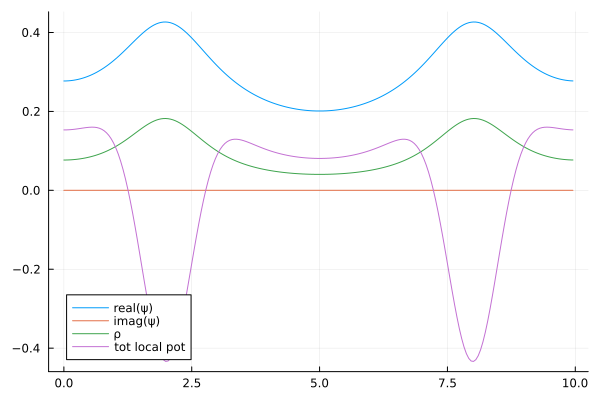

In [12]:
ψ = ifft(basis, basis.kpoints[1], ψ_fourier)[:, 1, 1]
ψ /= (ψ[div(end, 2)] / abs(ψ[div(end, 2)]));

using Plots
x = a * vec(first.(DFTK.r_vectors(basis)))
p = plot(x, real.(ψ), label="real(ψ)")
plot!(p, x, imag.(ψ), label="imag(ψ)")
plot!(p, x, ρ, label="ρ")
plot!(p, x, tot_local_pot, label="tot local pot")